In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# dataset generation

block_size = 3
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27,2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [8]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [9]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [10]:
#### Neural Net starts ####

In [11]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [12]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [13]:
sum(p.nelement() for p in parameters) # Number of params

3481

In [14]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims = True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052, grad_fn=<NllLossBackward0>)

In [15]:
# without batches
for _ in range(20):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084484100341797
15.776529312133789
14.83333683013916
14.002596855163574
13.253254890441895
12.579914093017578
11.983097076416016
11.470491409301758
11.05185604095459
10.709586143493652
10.407631874084473
10.127808570861816
9.86436653137207
9.61450481414795
9.37644100189209
9.148946762084961
8.931112289428711
8.722232818603516
8.52175235748291


In [16]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [17]:
# with batches

# lri = []
# lossi = []

for i in range(100000):

    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #update stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.4384543895721436


In [19]:
#plt.plot(lri, lossi)

In [20]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4076, grad_fn=<NllLossBackward0>)

In [21]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [22]:
# dataset generation with splits

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [29]:
# with batches and train dataset

for i in range(100000):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.0628502368927


In [30]:
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2582, grad_fn=<NllLossBackward0>)

In [32]:
# train loss -- both dev loss and train loss are similar, which indicates we are not overfitting
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2538, grad_fn=<NllLossBackward0>)

** Increasing the size of neural net **

In [33]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

10281

In [64]:
# with batches and train dataset with bigger MLP

for i in range(100000):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.1749155521392822


In [65]:
# train loss 
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2496, grad_fn=<NllLossBackward0>)

In [66]:
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2572, grad_fn=<NllLossBackward0>)

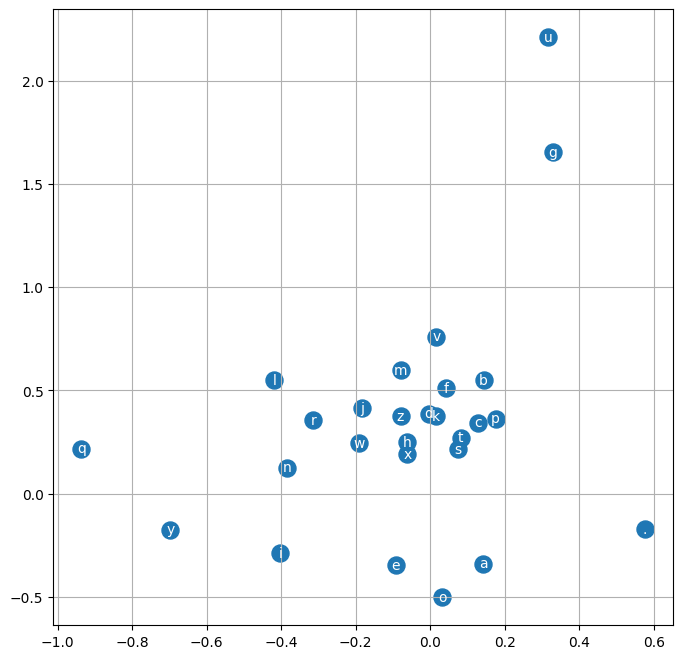

In [75]:
# Visualize the embeddings - works only for 2D
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=150)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [76]:
# increasing the embedding space

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

In [84]:
# with batches and train dataset with bigger MLP and embedding space

for i in range(50000):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

1.9133046865463257


In [85]:
# train loss 
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0989, grad_fn=<NllLossBackward0>)

In [86]:
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1487, grad_fn=<NllLossBackward0>)

In [87]:
parameters_2_148 = parameters

In [90]:
#sampling from the model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

dex
mariah
makileik
ahnee
jimitta
noluwan
kaida
samiyah
javarii
tai
molise
kau
keiteda
kaley
maside
eniavion
rosley
hani
evatallys
dasir


In [95]:
torch.save(parameters_2_148, 'parameters_2_148.pt')